In [1]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Physical-Informed model of well

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
# import wandb

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Pre-processing dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# cd /content/drive/MyDrive/ml

In [5]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Data/28032023/Архив.zip","r") as z:
    z.extractall(".")

In [6]:
# data = np.load('K-P_stationary-new-normalised.npy')
perm = np.load('perm1_1600.npy')
pressure = np.load('pressure1_1600.npy')
# perm = perm / np.mean(perm)
# pressure = pressure / np.mean(pressure)
print(perm.shape, pressure.shape)

(1600, 64, 64) (1600, 21, 64, 64)


In [7]:
# perms, pressures, rates = [], [], []
perms, pressures = [], []
for i in range(len(pressure)):
    if np.mean(pressure[i])>300.0:
        pass
    else:
        perms.append(perm[i])
        pressures.append(pressure[i])
        #rates.append(rate[i])

print(len(perms) == len(pressures)) #== len(rates)


np.save('perms_clear.npy', perms)
np.save('pressures_clear.npy', pressures)
#np.save('rates_clear.npy', rates)

perms = np.array(perms)
pressures = np.array(pressures)

True


In [8]:
print(perms.shape, pressures.shape)

(1317, 64, 64) (1317, 21, 64, 64)


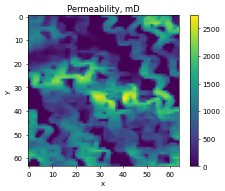

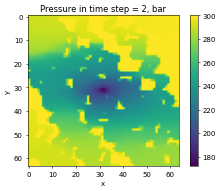

In [9]:
plt.figure(dpi=50)
plt.imshow(perm[1])
plt.subplots_adjust()
plt.colorbar()
plt.title('Permeability, mD')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(dpi=50)
i = 2
plt.imshow(pressure[1][i])
plt.subplots_adjust()
plt.colorbar()
plt.title(f'Pressure in time step = {i}, bar')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Dataset

In [10]:
x, y = [], []
for i in tqdm(range(len(pressures))):
    for j in range(len(pressures[i])):
      if j == 3:
          inp = np.stack((perms[i]))
          x.append(inp)
          out = np.reshape(pressures[i][j],(1,64,64))
          y.append(out)
x = np.stack(tuple(x)).reshape(-1, 1, 64, 64)
y = np.stack(tuple(y))

100%|██████████| 1317/1317 [00:00<00:00, 5088.92it/s]


In [11]:
print(f'x shape {x.shape}\ny shape {y.shape}')

x shape (1317, 1, 64, 64)
y shape (1317, 1, 64, 64)


In [12]:
# x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
# x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=False)
total_size = x.shape[0]
bs = 13
total_batches = total_size / bs
train_test_split_values = np.floor(np.array([0.8, 0.1, 0.1]) * total_batches) * bs
ths = train_test_split_values.astype(int)
print(ths)

x_train = x[0:ths[0]]
y_train = y[0:ths[0]]
x_val = x[ths[0]:ths[0]+ths[1]]
y_val = y[ths[0]:ths[0]+ths[1]]
x_test = x[ths[0]+ths[1]:ths[0]+ths[1]+ths[2]]
y_test = y[ths[0]+ths[1]:ths[0]+ths[1]+ths[2]]


print(f'The train size {len(x_train)}',
      f'\nThe val size {len(x_val)}',
     f'\nThe test size {len(x_test)}')

x_train = torch.from_numpy(x_train).to(device)
x_val = torch.from_numpy(x_val).to(device)
x_test = torch.from_numpy(x_test).to(device)
y_train = torch.from_numpy(y_train).to(device)
y_val = torch.from_numpy(y_val).to(device)
y_test = torch.from_numpy(y_test).to(device)

[1053  130  130]
The train size 1053 
The val size 130 
The test size 130


In [13]:
!nvidia-smi

Tue Mar 28 17:11:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    659MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=len(x_test), shuffle=False, num_workers=0)

# Model architecture

In [15]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
#         return torch.sigmoid(self.conv(dec1))
        return self.conv(dec1)


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [16]:
# from torchsummary import summary

# summary(model, input_size=(2,64, 64))

# Adding losses

In [56]:
def loss_data(h_real, h_pred):
    # return torch.sqrt(torch.mean(torch.square(h_real - h_pred)))
    return torch.mean(torch.square(h_real - h_pred))

In [57]:
def torch_gradient(input, h, dx=200, dy=100):
    K = input[:, 0, :, :].view(-1, 1, 64, 64) # .to(device, torch.float)
    # print(K.shape, h.shape)
    n_channels = h.shape[1]
    # h = h.to(device, torch.float)

    dhx, dhy = torch.gradient(h, spacing=(dx, dy), dim=(2, 3))
    Kdhx = torch.repeat_interleave(K, 1, dim=1) * dhx
    Kdhy = torch.repeat_interleave(K, 1, dim=1) * dhy

    dKdhx = torch.gradient(Kdhx, spacing=dx, dim=2)[0]
    dKdhy = torch.gradient(Kdhy, spacing=dy, dim=3)[0]

    return dKdhx + dKdhy

In [58]:
def hdt(h, S=5, dt=30*86400):
    partial_t = S * torch.gradient(h, spacing=dt, dim=0)[0]
    return partial_t

In [59]:
def loss_pde(input, h_pred, dx=200, dy=100, S=1e-4, dt=365*86400):
    nabla_K_nabla_h = torch_gradient(input, h_pred, dx=dx, dy=dy)
    # Sdhdt = hdt(h_pred, S=S, dt=dt)
    # return torch.sqrt(torch.mean(torch.square(nabla_K_nabla_h)))
    return torch.mean(torch.square(nabla_K_nabla_h))

## Model training

# Data

In [75]:
for batch in train_loader:
    sample, target = batch
    break

In [76]:
sample.shape, target.shape

(torch.Size([13, 1, 64, 64]), torch.Size([13, 1, 64, 64]))

In [97]:
model = UNet(in_channels=1, out_channels=1, init_features=64)
path = '/content/drive/MyDrive/Data/28032023/Res/'
logging = []
mltplr = 1e4

def train(model, opt, criterion, n_epochs, scheduler):

    min_val_loss = np.inf
    for epoch in range(n_epochs):
        model.train()
        
        train_batch_loss = []
        train_batch_data_loss = []
        train_batch_pde_loss = []
        for batch in train_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            #print(sample.shape, target.shape)
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = data_loss # + pde_loss
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            train_batch_data_loss.append(data_loss.item())
            train_batch_pde_loss.append(pde_loss.item())

        train_loss = np.mean(train_batch_loss)
        train_data_loss = np.mean(train_batch_data_loss)
        train_pde_loss = np.mean(train_batch_pde_loss)
    
        model.eval()
        
        val_batch_loss = []
        val_batch_data_loss = []
        val_batch_pde_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = data_loss

            val_batch_loss.append(loss.item())
            val_batch_data_loss.append(data_loss.item())
            val_batch_pde_loss.append(pde_loss.item())
            
        val_loss = np.mean(val_batch_loss)
        val_data_loss = np.mean(val_batch_data_loss)
        val_pde_loss = np.mean(val_batch_pde_loss)

        scheduler.step(val_loss)
               
        logging.append(np.array([epoch, train_loss, train_data_loss, train_pde_loss, val_loss, val_data_loss, val_pde_loss]))
        if val_loss > min_val_loss:
            f+=1
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
        else:
            print(f'epoch: {epoch}, val loss did decrease, saving model')
            f=0
            folder = path
            model_name_cur = f'PINN_steady_DATA_current.pth'
            model_path = folder + model_name_cur
            torch.save(model, model_path)
            min_val_loss = val_loss
        
        if f>=10:
            break
        
        print(f'epoch: {epoch}, TRAIN_LOSS: [TOTAL: {round(train_loss, 1)} DATA: {round(train_data_loss, 1)}, PDE: {round(train_pde_loss, 1)}], \tVAL LOSS: [TOTAL: TOTAL: {round(val_loss, 1)} DATA: {round(val_data_loss, 1)}, PDE: {round(val_pde_loss, 1)}]')
        # wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        
        # если в течение 10 эпох ошибка на валидации не уменьшается, то прерываем обучение

# wandb.init(project="PINN_non_steady_1000_epoch_early_stop_sch")

'''
if torch.cuda.device_count() > 1:
    print("GPUs:", torch.cuda.device_count())
    model = nn.DataParallel(model, device_ids=[2, 3])
'''

model = UNet(in_channels=1, out_channels=1, init_features=64)
model.to(device)
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 1000
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
criterion = nn.MSELoss()

train(model, opt, criterion, n_epochs, scheduler=scheduler)

epoch: 0, val loss did decrease, saving model
epoch: 0, TRAIN_LOSS: [TOTAL: 73559.8 DATA: 73559.8, PDE: 7.2], 	VAL LOSS: [TOTAL: TOTAL: 72481.0 DATA: 72481.0, PDE: 13.7]
epoch: 1, val loss did decrease, saving model
epoch: 1, TRAIN_LOSS: [TOTAL: 71962.4 DATA: 71962.4, PDE: 26.0], 	VAL LOSS: [TOTAL: TOTAL: 70535.6 DATA: 70535.6, PDE: 33.6]
epoch: 2, val loss did decrease, saving model
epoch: 2, TRAIN_LOSS: [TOTAL: 69678.9 DATA: 69678.9, PDE: 69.8], 	VAL LOSS: [TOTAL: TOTAL: 68311.7 DATA: 68311.7, PDE: 128.8]
epoch: 3, val loss did decrease, saving model
epoch: 3, TRAIN_LOSS: [TOTAL: 66684.0 DATA: 66684.0, PDE: 518.5], 	VAL LOSS: [TOTAL: TOTAL: 64454.7 DATA: 64454.7, PDE: 1003.3]
epoch: 4, val loss did decrease, saving model
epoch: 4, TRAIN_LOSS: [TOTAL: 62883.6 DATA: 62883.6, PDE: 1699.4], 	VAL LOSS: [TOTAL: TOTAL: 60078.5 DATA: 60078.5, PDE: 2842.3]
epoch: 5, val loss did decrease, saving model
epoch: 5, TRAIN_LOSS: [TOTAL: 58508.4 DATA: 58508.4, PDE: 3102.7], 	VAL LOSS: [TOTAL: TOTAL:

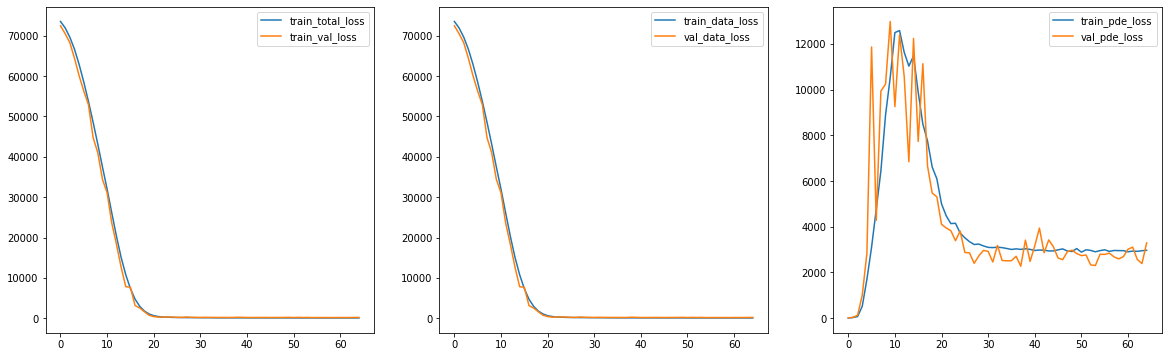

In [98]:
logging = np.array(logging)
np.save('/content/drive/MyDrive/Data/28032023/Res/logging_DATA_v2.npy',logging)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.plot(logging[:,0], logging[:,1], label='train_total_loss')
ax1.plot(logging[:,0], logging[:,4], label='train_val_loss')
ax1.legend()

ax2.plot(logging[:,0], logging[:,2], label='train_data_loss')
ax2.plot(logging[:,0], logging[:,5], label='val_data_loss')
ax2.legend()

ax3.plot(logging[:,0], logging[:,3], label='train_pde_loss')
ax3.plot(logging[:,0], logging[:,6], label='val_pde_loss')
ax3.legend()

plt.savefig('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_DATA_errors.png')

## Results

In [99]:
# folder = path
# model_path_cur = folder+'PINN_non_steady_DATA_v2_current.pth'
# model = torch.load(model_path_cur)
# model.to(device)
# model.eval()

In [100]:
for batch in test_loader:
    sample, target = batch
    sample, target = sample.to(device, torch.float), target.to(device, torch.float)

In [101]:
with torch.no_grad():
    pred = model(sample)
    test_data_loss = loss_data(target, pred)
    test_pde_loss = mltplr*loss_pde(sample, pred)
    test_total_loss = test_data_loss# + pde_loss

In [102]:
test_data_loss, test_pde_loss, test_total_loss = test_data_loss.cpu().numpy(), test_pde_loss.cpu().numpy(), test_total_loss.cpu().numpy()

In [103]:
print(f'TEST_LOSS: [TOTAL: {np.round(np.sqrt(test_total_loss), 1)} DATA: {np.round(np.sqrt(test_data_loss), 1)}, PDE: {np.round(np.sqrt(test_pde_loss), 1)}]')

TEST_LOSS: [TOTAL: 13.699999809265137 DATA: 13.699999809265137, PDE: 56.400001525878906]


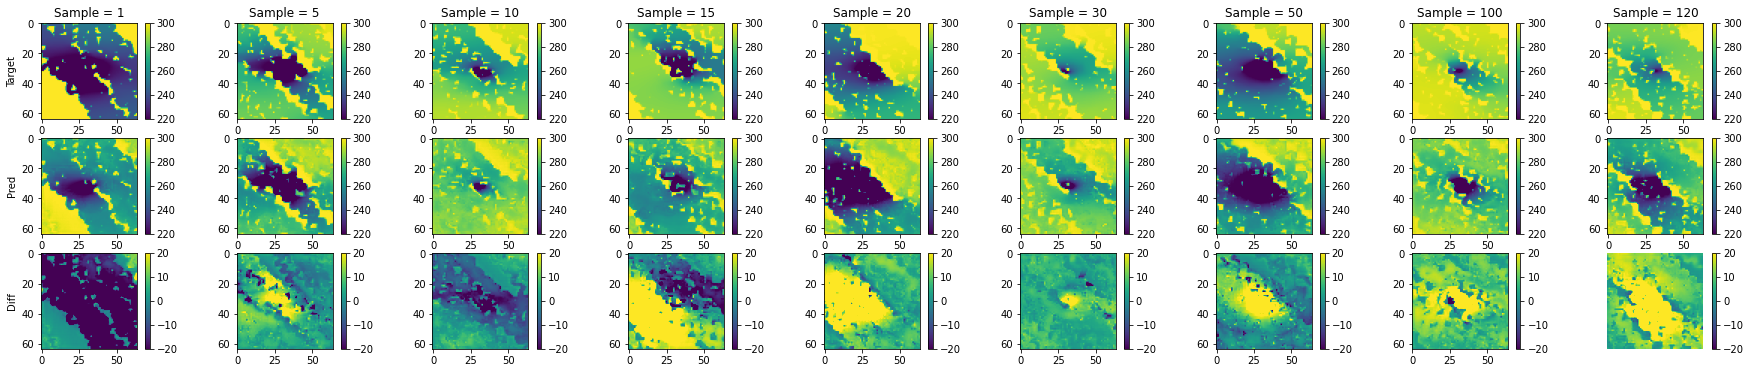

In [104]:
indx = [1, 5, 10, 15, 20, 30, 50, 100, 120]

fig, axes = plt.subplots(3, len(indx), figsize=(31, 6))
vmin, vmax = 220, 300

for (i, sam) in enumerate(indx):
    axes[0, i].set_title(f'Sample = {sam}')
    axes[0, 0].set_ylabel('Target')
    axes[1, 0].set_ylabel('Pred')
    axes[2, 0].set_ylabel('Diff')
    tar = target[sam, 0, :, :].cpu().numpy()
    pre = pred[sam, 0, :, :].detach().cpu().numpy()
    diff = tar - pre
    sc = axes[0, i].imshow(tar, vmin=vmin, vmax=vmax)
    fig.colorbar(sc, ax=axes[0, i])
    sc = axes[1, i].imshow(pre, vmin=vmin, vmax=vmax)
    fig.colorbar(sc, ax=axes[1, i])
    sc = axes[2, i].imshow(diff, vmin=-20, vmax=20)
    fig.colorbar(sc, ax=axes[2, i])

plt.axis('off')

plt.savefig('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_DATA_plots.png')

In [118]:
model = torch.load('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_DATA_current.pth')
model.to(device)
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [119]:
test_loss = []

for i in tqdm(range(len(test_dataset))):
    sample, target = test_dataset[i]
    sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
    pred = model(sample.unsqueeze(0))
    loss = loss_data(pred[0], target)
    test_loss.append(np.sqrt(loss.item()))

print(f'RMSE: {np.mean(test_loss)}')

100%|██████████| 130/130 [00:00<00:00, 132.76it/s]

RMSE: 10.606121147804581


# Data + PDE

In [105]:
model = UNet(in_channels=1, out_channels=1, init_features=64)

logging = []
mltplr = 1e4

def train(model, opt, criterion, n_epochs, scheduler):

    min_val_loss = np.inf
    for epoch in range(n_epochs):
        model.train()
        
        train_batch_loss = []
        train_batch_data_loss = []
        train_batch_pde_loss = []
        for batch in train_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = data_loss + pde_loss
            if torch.isnan(loss):
                break
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            train_batch_data_loss.append(data_loss.item())
            train_batch_pde_loss.append(pde_loss.item())

        train_loss = np.mean(train_batch_loss)
        train_data_loss = np.mean(train_batch_data_loss)
        train_pde_loss = np.mean(train_batch_pde_loss)
    
        model.eval()
        
        val_batch_loss = []
        val_batch_data_loss = []
        val_batch_pde_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = data_loss + pde_loss

            val_batch_loss.append(loss.item())
            val_batch_data_loss.append(data_loss.item())
            val_batch_pde_loss.append(pde_loss.item())
            
        val_loss = np.mean(val_batch_loss)
        val_data_loss = np.mean(val_batch_data_loss)
        val_pde_loss = np.mean(val_batch_pde_loss)

        scheduler.step(val_loss)
               
        logging.append(np.array([epoch, train_loss, train_data_loss, train_pde_loss, val_loss, val_data_loss, val_pde_loss]))
        if val_loss > min_val_loss:
            f+=1
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
        else:
            print(f'epoch: {epoch}, val loss did decrease, saving model')
            f=0
            folder = path
            model_name_cur = f'PINN_steady_DATA_PDE_current.pth'
            model_path = folder + model_name_cur
            torch.save(model, model_path)
            min_val_loss = val_loss
        
        if f>=10:
            break
        
        print(f'epoch: {epoch}, TRAIN_LOSS: [TOTAL: {round(train_loss, 1)} DATA: {round(train_data_loss, 1)}, PDE: {round(train_pde_loss, 1)}], \tVAL LOSS: [TOTAL: TOTAL: {round(val_loss, 1)} DATA: {round(val_data_loss, 1)}, PDE: {round(val_pde_loss, 1)}]')
        # wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        
        # если в течение 10 эпох ошибка на валидации не уменьшается, то прерываем обучение

# wandb.init(project="PINN_non_steady_1000_epoch_early_stop_sch")

'''
if torch.cuda.device_count() > 1:
    print("GPUs:", torch.cuda.device_count())
    model = nn.DataParallel(model, device_ids=[2, 3])
'''

model = UNet(in_channels=1, out_channels=1, init_features=64)
model.to(device)
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
criterion = nn.MSELoss()

train(model, opt, criterion, n_epochs, scheduler=scheduler)

epoch: 0, val loss did decrease, saving model
epoch: 0, TRAIN_LOSS: [TOTAL: 73527.5 DATA: 73522.9, PDE: 4.6], 	VAL LOSS: [TOTAL: TOTAL: 72544.7 DATA: 72539.2, PDE: 5.5]
epoch: 1, val loss did decrease, saving model
epoch: 1, TRAIN_LOSS: [TOTAL: 71883.5 DATA: 71874.1, PDE: 9.4], 	VAL LOSS: [TOTAL: TOTAL: 70311.5 DATA: 70298.4, PDE: 13.1]
epoch: 2, val loss did decrease, saving model
epoch: 2, TRAIN_LOSS: [TOTAL: 69412.9 DATA: 69403.7, PDE: 9.1], 	VAL LOSS: [TOTAL: TOTAL: 67192.3 DATA: 67175.1, PDE: 17.2]
epoch: 3, val loss did decrease, saving model
epoch: 3, TRAIN_LOSS: [TOTAL: 66150.3 DATA: 66137.0, PDE: 13.3], 	VAL LOSS: [TOTAL: TOTAL: 64052.6 DATA: 64038.3, PDE: 14.3]
epoch: 4, val loss did decrease, saving model
epoch: 4, TRAIN_LOSS: [TOTAL: 62236.4 DATA: 62219.7, PDE: 16.8], 	VAL LOSS: [TOTAL: TOTAL: 61316.4 DATA: 61298.3, PDE: 18.1]
epoch: 5, val loss did decrease, saving model
epoch: 5, TRAIN_LOSS: [TOTAL: 57790.8 DATA: 57766.5, PDE: 24.3], 	VAL LOSS: [TOTAL: TOTAL: 58781.9 DATA

TEST_LOSS: [TOTAL: 14.600000381469727 DATA: 13.800000190734863, PDE: 4.800000190734863]


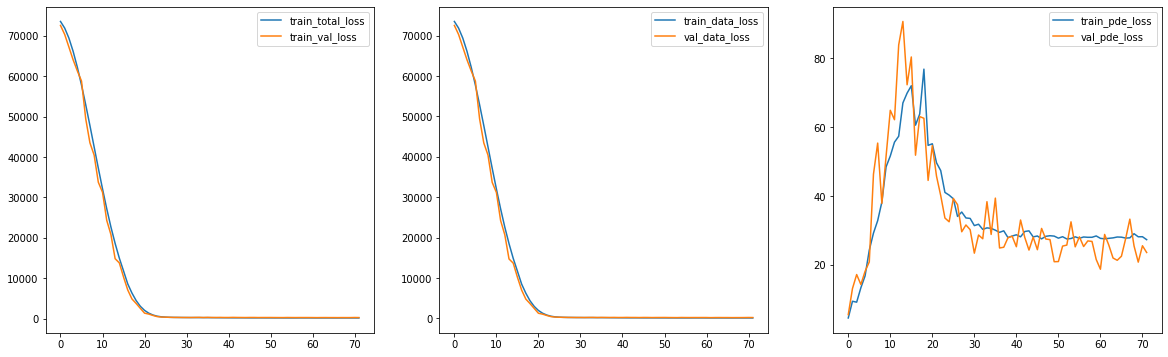

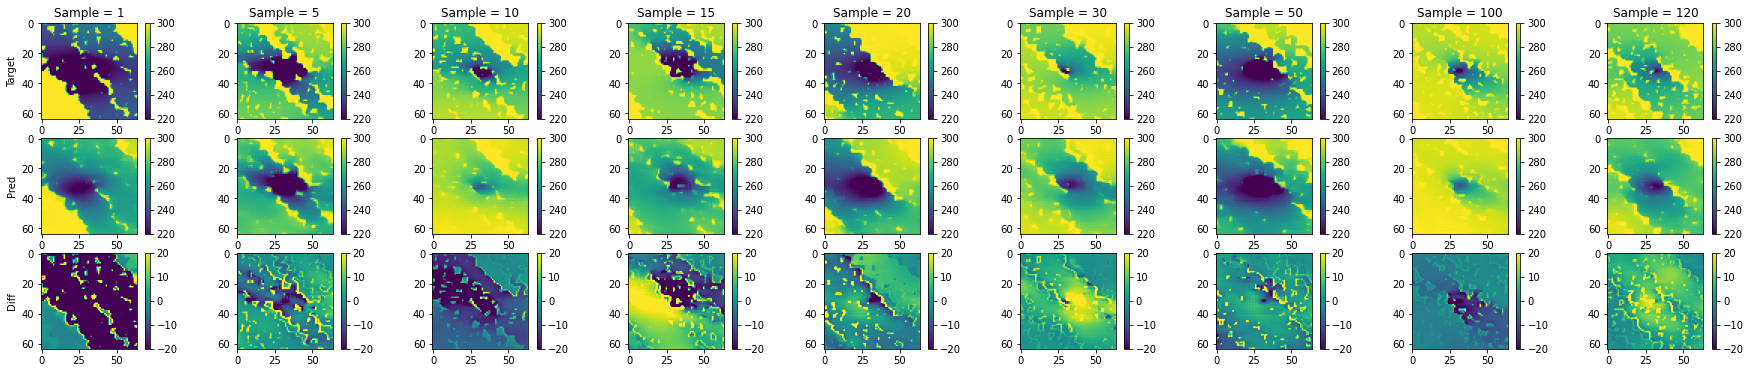

In [106]:
logging = np.array(logging)
np.save('/content/drive/MyDrive/Data/28032023/Res/logging_DATA_PDE_v2.npy',logging)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.plot(logging[:,0], logging[:,1], label='train_total_loss')
ax1.plot(logging[:,0], logging[:,4], label='train_val_loss')
ax1.legend()

ax2.plot(logging[:,0], logging[:,2], label='train_data_loss')
ax2.plot(logging[:,0], logging[:,5], label='val_data_loss')
ax2.legend()

ax3.plot(logging[:,0], logging[:,3], label='train_pde_loss')
ax3.plot(logging[:,0], logging[:,6], label='val_pde_loss')
ax3.legend()

plt.savefig('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_DATA_PDE_errors.png')

# model_path_cur = folder+'PINN_non_steady_DATA_PDE_v2_current.pth'
# model = torch.load(model_path_cur)
# model.to(device)
# model.eval()

for batch in test_loader:
    sample, target = batch
    sample, target = sample.to(device, torch.float), target.to(device, torch.float)

with torch.no_grad():
    pred = model(sample)
    test_data_loss = loss_data(target, pred)
    test_pde_loss = mltplr*loss_pde(sample, pred)
    test_total_loss = test_data_loss + test_pde_loss # + pde_loss
    
test_data_loss, test_pde_loss, test_total_loss = test_data_loss.cpu().numpy(), test_pde_loss.cpu().numpy(), test_total_loss.cpu().numpy()
    
indx = [1, 5, 10, 15, 20, 30, 50, 100, 120]

fig, axes = plt.subplots(3, len(indx), figsize=(31, 6))
vmin, vmax = 220, 300

for (i, sam) in enumerate(indx):
    axes[0, i].set_title(f'Sample = {sam}')
    axes[0, 0].set_ylabel('Target')
    axes[1, 0].set_ylabel('Pred')
    axes[2, 0].set_ylabel('Diff')
    tar = target[sam, 0, :, :].cpu().numpy()
    pre = pred[sam, 0, :, :].detach().cpu().numpy()
    diff = tar - pre
    sc = axes[0, i].imshow(tar, vmin=vmin, vmax=vmax)
    fig.colorbar(sc, ax=axes[0, i])
    sc = axes[1, i].imshow(pre, vmin=vmin, vmax=vmax)
    fig.colorbar(sc, ax=axes[1, i])
    sc = axes[2, i].imshow(diff, vmin=-20, vmax=20)
    fig.colorbar(sc, ax=axes[2, i])

plt.savefig('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_DATA_PDE_plots.png')

print(f'TEST_LOSS: [TOTAL: {np.round(np.sqrt(test_total_loss), 1)} DATA: {np.round(np.sqrt(test_data_loss), 1)}, PDE: {np.round(np.sqrt(test_pde_loss), 1)}]')

In [115]:
model = torch.load('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_DATA_PDE_current.pth')
model.to(device)
model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [116]:
test_loss = []

for i in tqdm(range(len(test_dataset))):
    sample, target = test_dataset[i]
    sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
    pred = model(sample.unsqueeze(0))
    loss = loss_data(pred[0], target)
    test_loss.append(np.sqrt(loss.item()))

print(f'RMSE: {np.mean(test_loss)}')

100%|██████████| 130/130 [00:01<00:00, 91.72it/s] 

RMSE: 13.249645657263066


# PDE

In [107]:
model = UNet(in_channels=1, out_channels=1, init_features=64)

logging = []
mltplr = 1e4

def train(model, opt, criterion, n_epochs, scheduler):

    min_val_loss = np.inf
    for epoch in range(n_epochs):
        model.train()
        
        train_batch_loss = []
        train_batch_data_loss = []
        train_batch_pde_loss = []
        for batch in train_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float) 
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = pde_loss
            if torch.isnan(loss):
                break
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            train_batch_data_loss.append(data_loss.item())
            train_batch_pde_loss.append(pde_loss.item())

        train_loss = np.mean(train_batch_loss)
        train_data_loss = np.mean(train_batch_data_loss)
        train_pde_loss = np.mean(train_batch_pde_loss)
    
        model.eval()
        
        val_batch_loss = []
        val_batch_data_loss = []
        val_batch_pde_loss = []
        for batch in val_loader:
            sample, target = batch
            sample, target = sample.to(device, torch.float), target.to(device, torch.float)
            pred = model(sample)

            data_loss = loss_data(target, pred)
            pde_loss = mltplr*loss_pde(sample, pred)
            loss = pde_loss

            val_batch_loss.append(loss.item())
            val_batch_data_loss.append(data_loss.item())
            val_batch_pde_loss.append(pde_loss.item())
            
        val_loss = np.mean(val_batch_loss)
        val_data_loss = np.mean(val_batch_data_loss)
        val_pde_loss = np.mean(val_batch_pde_loss)

        scheduler.step(val_loss)
               
        logging.append(np.array([epoch, train_loss, train_data_loss, train_pde_loss, val_loss, val_data_loss, val_pde_loss]))
        if val_loss > min_val_loss:
            f+=1
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
        else:
            print(f'epoch: {epoch}, val loss did decrease, saving model')
            f=0
            #folder = path
            model_name_cur = f'PINN_steady_PDE_current.pth'
            #model_path = folder + model_name_cur
            torch.save(model, '/content/drive/MyDrive/Data/28032023/Res/PINN_steady_PDE_current.pth')
            min_val_loss = val_loss
        
        if f>=10:
            break
        
        print(f'epoch: {epoch}, TRAIN_LOSS: [TOTAL: {round(train_loss, 1)} DATA: {round(train_data_loss, 1)}, PDE: {train_pde_loss}], \tVAL LOSS: [TOTAL: TOTAL: {round(val_loss, 1)} DATA: {round(val_data_loss, 1)}, PDE: {val_pde_loss}]')
        # wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
        
        # если в течение 10 эпох ошибка на валидации не уменьшается, то прерываем обучение

# wandb.init(project="PINN_non_steady_1000_epoch_early_stop_sch")

'''
if torch.cuda.device_count() > 1:
    print("GPUs:", torch.cuda.device_count())
    model = nn.DataParallel(model, device_ids=[2, 3])
'''

model = UNet(in_channels=1, out_channels=1, init_features=64)
model.to(device)
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 100
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
criterion = nn.MSELoss()

train(model, opt, criterion, n_epochs, scheduler=scheduler)

epoch: 0, val loss did decrease, saving model
epoch: 0, TRAIN_LOSS: [TOTAL: 0.5 DATA: 74422.8, PDE: 0.5096934582164259], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 73969.7, PDE: 0.010443370882421732]
epoch: 1, val loss did decrease, saving model
epoch: 1, TRAIN_LOSS: [TOTAL: 0.0 DATA: 74431.7, PDE: 0.006777910400687912], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 73973.2, PDE: 0.00606977385468781]
epoch: 2, val loss did decrease, saving model
epoch: 2, TRAIN_LOSS: [TOTAL: 0.0 DATA: 74435.9, PDE: 0.004125951691588134], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 73975.8, PDE: 0.0037469848990440368]
epoch: 3, val loss did decrease, saving model
epoch: 3, TRAIN_LOSS: [TOTAL: 0.0 DATA: 74438.3, PDE: 0.00290813420922208], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 73977.3, PDE: 0.002750070858746767]
epoch: 4, val loss did decrease, saving model
epoch: 4, TRAIN_LOSS: [TOTAL: 0.0 DATA: 74439.7, PDE: 0.0021745586282010247], 	VAL LOSS: [TOTAL: TOTAL: 0.0 DATA: 73977.9, PDE: 0.0022168987547047437]
epoch: 5, val loss did dec

TEST_LOSS: [TOTAL: 0.0 DATA: 274.5, PDE: 0.0]


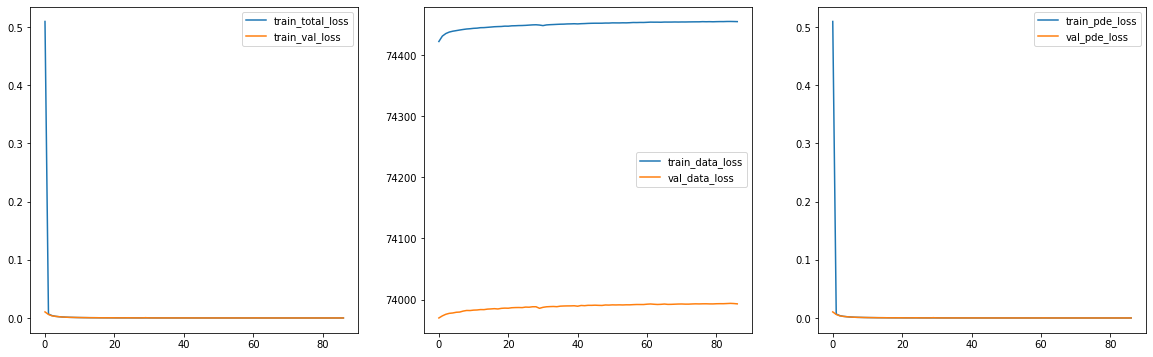

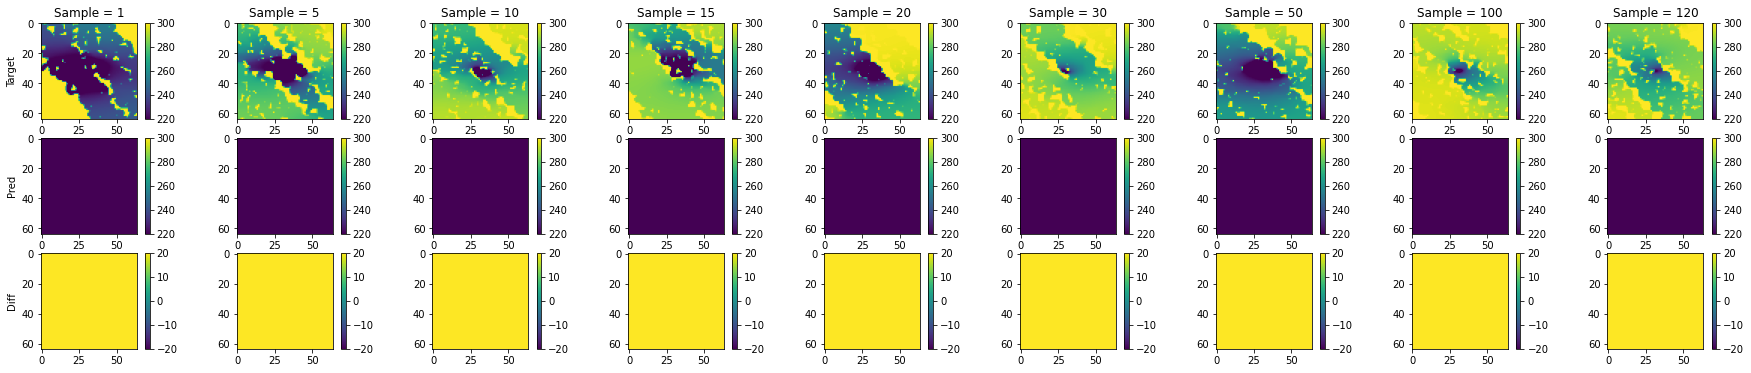

In [111]:
logging = np.array(logging)
np.save('/content/drive/MyDrive/Data/28032023/Res/logging_PDE_v2.npy',logging)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.plot(logging[:,0], logging[:,1], label='train_total_loss')
ax1.plot(logging[:,0], logging[:,4], label='train_val_loss')
ax1.legend()

ax2.plot(logging[:,0], logging[:,2], label='train_data_loss')
ax2.plot(logging[:,0], logging[:,5], label='val_data_loss')
ax2.legend()

ax3.plot(logging[:,0], logging[:,3], label='train_pde_loss')
ax3.plot(logging[:,0], logging[:,6], label='val_pde_loss')
ax3.legend()

plt.savefig('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_PDE_errors.png')

# model_path_cur = folder+'PINN_non_steady_DATA_PDE_v2_current.pth'
# model = torch.load(model_path_cur)
# model.to(device)
# model.eval()

for batch in test_loader:
    sample, target = batch
    sample, target = sample.to(device, torch.float), target.to(device, torch.float)

with torch.no_grad():
    pred = model(sample)
    test_data_loss = loss_data(target, pred)
    test_pde_loss = mltplr*loss_pde(sample, pred)
    test_total_loss = test_pde_loss # + pde_loss
    
test_data_loss, test_pde_loss, test_total_loss = test_data_loss.cpu().numpy(), test_pde_loss.cpu().numpy(), test_total_loss.cpu().numpy()
    
indx = [1, 5, 10, 15, 20, 30, 50, 100, 120]

fig, axes = plt.subplots(3, len(indx), figsize=(31, 6))
vmin, vmax = 220, 300

for (i, sam) in enumerate(indx):
    axes[0, i].set_title(f'Sample = {sam}')
    axes[0, 0].set_ylabel('Target')
    axes[1, 0].set_ylabel('Pred')
    axes[2, 0].set_ylabel('Diff')
    tar = target[sam, 0, :, :].cpu().numpy()
    pre = pred[sam, 0, :, :].detach().cpu().numpy()
    diff = tar - pre
    sc = axes[0, i].imshow(tar, vmin=vmin, vmax=vmax)
    fig.colorbar(sc, ax=axes[0, i])
    sc = axes[1, i].imshow(pre, vmin=vmin, vmax=vmax)
    fig.colorbar(sc, ax=axes[1, i])
    sc = axes[2, i].imshow(diff, vmin=-20, vmax=20)
    fig.colorbar(sc, ax=axes[2, i])

plt.savefig('/content/drive/MyDrive/Data/28032023/Res/PINN_steady_PDE_plots.png')

print(f'TEST_LOSS: [TOTAL: {np.round(np.sqrt(test_total_loss), 1)} DATA: {np.round(np.sqrt(test_data_loss), 1)}, PDE: {np.round(np.sqrt(test_pde_loss), 1)}]')

In [109]:
# def one_prediction_with_x(idx):
#     ex_x, ex_y = test_dataset[idx]
#     ex_pred = model(ex_x.unsqueeze(0).to(device, dtype=torch.float)).cpu().detach().numpy()[0]
#     target = ex_y.cpu().numpy()[0]
#     pred = ex_pred[0]
#     diff = ex_y.cpu().numpy()[0] - ex_pred[0]
#     return target, pred, diff, ex_x.cpu().numpy()[0]

In [110]:
# fig, axes = plt.subplots(1, 4, figsize=(12,2), dpi=200)
# target, pred, diff, k = one_prediction_with_x(4)
# true = axes[0].imshow(k)
# axes[0].set_title(f'Permeability, mD')
# fig.colorbar(true, ax=axes[0])
# true = axes[1].imshow(target, vmin = np.min(target), vmax = np.max(target))
# axes[1].set_title(f'Target, bar, time={3}')
# fig.colorbar(true, ax=axes[1])
# true = axes[2].imshow(pred, vmin = np.min(pred), vmax = np.max(pred))
# axes[2].set_title(f'Predict, bar, time={3}')
# fig.colorbar(true, ax=axes[2])
# true = axes[3].imshow(diff)
# axes[3].set_title(f'Difference, bar')
# fig.colorbar(true, ax=axes[3])
# plt.show()